In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# import my regular season data
dfTeamData = pd.read_hdf('pyData/regSeasonData.h5')

In [3]:
# Create np matrix containing all data
teamDataMat = (dfTeamData.loc[:,'FG':'oppPTS']).to_numpy()
teamDataMat.shape

(626, 42)

I have 42 stats and 626 data points. Let's see how many stats I can reduce this by using PCA.

In [4]:
# Mean subtraction
statMean = np.mean(teamDataMat,axis=0)
teamDataZero = teamDataMat - statMean

In [5]:
N = teamDataZero.shape[0]
# covariance matrix
covMat = 1/N*np.dot(teamDataZero.T,teamDataZero)

# diagonlize
covLam,covVec = np.linalg.eig(covMat)
# get indexes of sorted eigenvalues
inds = np.argsort(covLam)

In [6]:
inds

array([40, 39, 41, 38, 37, 36, 35, 34, 32, 33, 31, 30, 29, 28, 27, 26, 25,
       24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,
        7,  6,  5,  4,  3,  2,  1,  0])

Text(0, 0.5, '$\\lambda_n$')

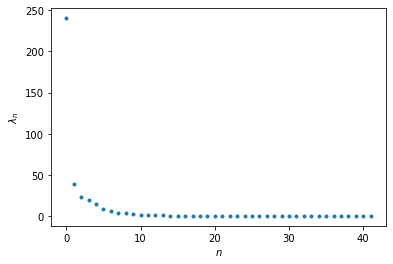

In [7]:
# plot eigenvalues
plt.figure()
plt.plot(np.arange(inds.size),covLam[inds[::-1]],'.')
plt.xlabel('$n$')
plt.ylabel(r'$\lambda_n$')

Text(0, 0.5, '$(\\Sigma^n \\lambda_m)/(\\Sigma^N \\lambda_m)$')

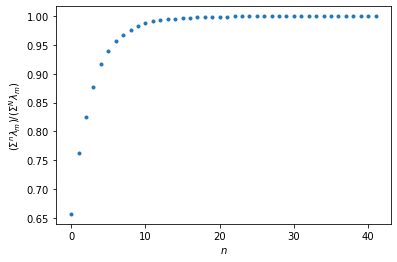

In [8]:
# plot normalized cumulative sum of eigenvalues
lamSum = np.cumsum(covLam[inds[::-1]])
totSum = np.sum(covLam)
plt.figure()
plt.plot(np.arange(covLam.size),lamSum/totSum,'.')
plt.xlabel('$n$')
plt.ylabel(r'$(\Sigma^n \lambda_m)/(\Sigma^N \lambda_m)$')

First 5 eigenvectors account for 90% of variance. First 7 account for 95%.

In [9]:
covVec[:,inds[-1]]

array([-1.25640537e-01, -2.08040699e-01, -3.69353404e-04, -1.66532117e-01,
       -4.51423732e-01, -2.97505681e-04,  4.10348852e-02,  2.43326584e-01,
       -1.32683885e-03,  2.36970281e-02,  4.54569017e-02, -4.65366835e-04,
        4.16393552e-02, -1.08917405e-01, -6.72445930e-02, -7.67998719e-02,
       -3.65932314e-03,  4.18999475e-03,  1.19905778e-02,  3.52873816e-02,
       -3.94029586e-01, -1.29655080e-01, -2.18583035e-01, -3.65149773e-04,
       -1.49082285e-01, -4.06759503e-01, -1.70889453e-04,  1.93243640e-02,
        1.88247576e-01, -1.22841854e-03,  2.70578273e-02,  4.83299122e-02,
       -4.19979692e-04,  3.13709042e-02, -1.14561234e-01, -8.30449379e-02,
       -8.06392175e-02, -3.65836662e-03,  3.97332692e-03,  8.98930614e-03,
        3.25915124e-02, -3.81276035e-01])

In [10]:
# plot first eigenvector
categories = dfTeamData.columns
categories = categories[2:].to_list() # names of each stat category (excluding Season and Tm)

<BarContainer object of 42 artists>

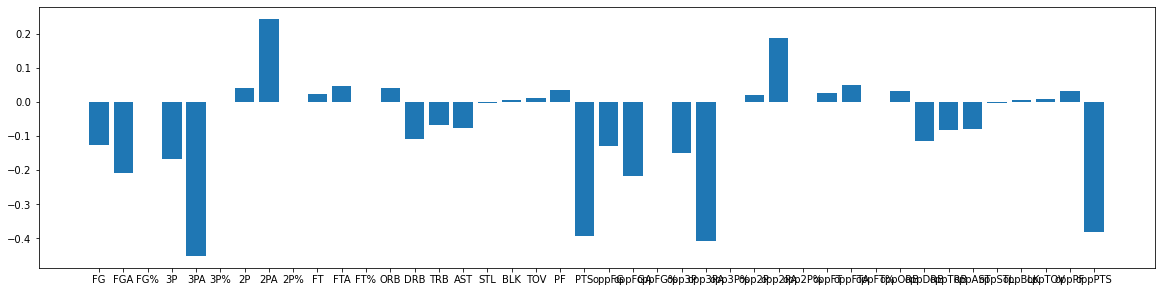

In [11]:
plt.figure(figsize=(20,4.8))
plt.bar(np.arange(len(categories)),covVec[:,inds[-1]],tick_label=categories)

This is too hard to read. Let me look at distribution of magnitudes of each component. 

(array([21., 10.,  4.,  1.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([1.29519717e-04, 5.82082659e-02, 1.16287012e-01, 1.74365758e-01,
        2.32444504e-01, 2.90523251e-01, 3.48601997e-01, 4.06680743e-01,
        4.64759489e-01, 5.22838235e-01, 5.80916982e-01]),
 <BarContainer object of 10 artists>)

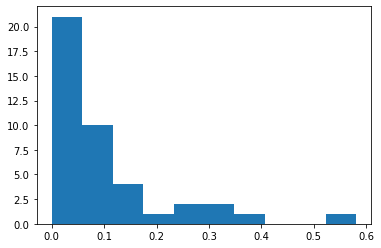

In [12]:
plt.figure()
plt.hist(np.abs(covVec[:,inds[-3]]))

Let me look at components whose magnitude is in top 10.

In [13]:
def visualizeVector(covVec,vecName=''):
    # sort covariance eigenvector by component magnitudes
    covInds = np.argsort(np.abs(covVec))
    # plot bar graph of top N components
    topN = 10
    labels = [categories[i] for i in covInds[-1:(-topN-1):-1]]
    vecVals = covVec[covInds[-1:(-topN-1):-1]]
    plt.figure()
    plt.bar(1.5*np.arange(topN),vecVals,tick_label=labels)
    plt.title('Covariance vector'+vecName)

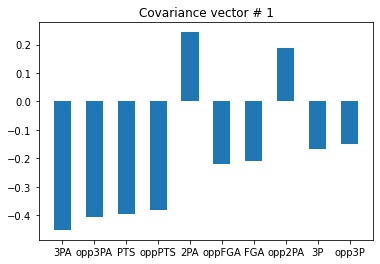

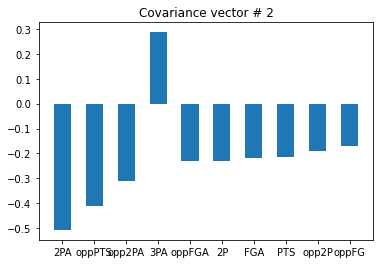

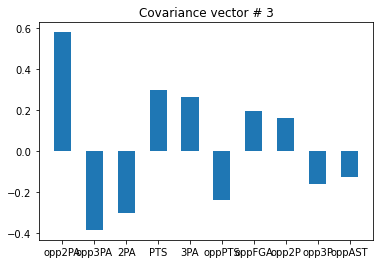

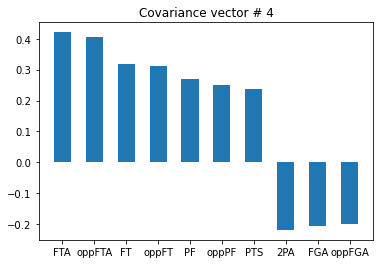

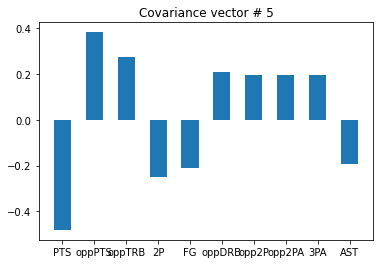

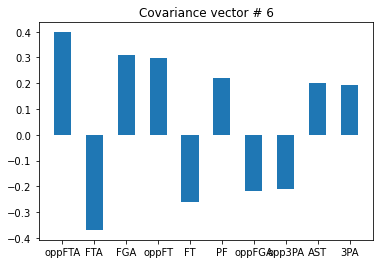

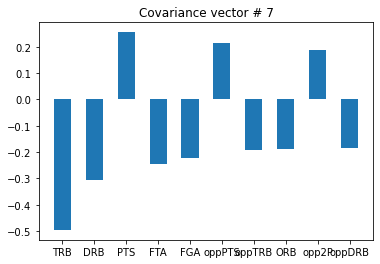

In [14]:
for i in range(1,8):
    visualizeVector(covVec[:,inds[-i]],' # '+str(i))

Potential interpretations for the covariance eigenvectors:
1. Score inside, block outside
    - positive --> scoring inside perimeter with strong perimeter defense
    - negative --> scoring outside perimeter, weak perimeter defense
2. Try outside, block inside
    - positive --> lots of shot attempts from outside perimeter, while effectively defending inside of perimeter
    - negative --> focusing scoring attempts and success inside perimeter, but bad defense inside perimeter
3. aggression, frustration, intensity? Mismatch between two teams?
    - seems to have same stats O and D with about same magnitude but opposite sign, but not in same direction each time
4. Physicality, contact - on both sides of the floor
    - positive - more contact, physicality
    - negative less
5. Squandering the ball
    - positive - opponents dominate the glass while you fail to score or move the ball
    - negative - you score, move the ball, and keep opponents off the glass
6. Foul trouble
    - positive - you foul a lot, while not getting fouled, you move the ball
    - negative - draw a lot of contact without fouling back, less ball movement
7. Playing like it's the all-star game
    - positive - Not much rebounding, but a lot of scoring
    - negative - a lof of rebounding at the cost of scoring

Surprising omissions:
- Shooting percentages did not make top 10 stats of any the top covariance vectors.
- Steals, blocks, turnovers all hidden out of top 10

Another question---are there any stats which are virtually uncorrelated from all the other stats?

[4.90794619e-07 9.90139411e-02 1.98027391e-01 2.97040842e-01
 3.96054292e-01 4.95067742e-01 5.94081192e-01 6.93094643e-01
 7.92108093e-01 8.91121543e-01 9.90134994e-01]
[1.20e+03 3.04e+02 1.43e+02 6.90e+01 2.10e+01 1.30e+01 5.00e+00 0.00e+00
 1.00e+00 8.00e+00]


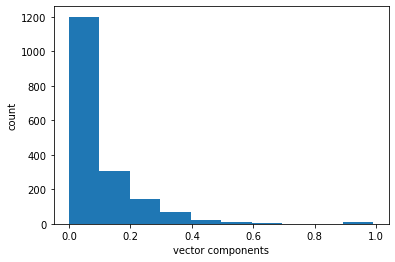

In [15]:
plt.figure()
hist, binEdges, patches = plt.hist(np.abs(covVec.flatten()))
plt.xlabel('vector components')
plt.ylabel('count')
print(binEdges)
print(hist)

There are 8 components which are between 0.89 and 0.99---because of normalization, they must belong to 8 separate eigenvectors. Would be good to know which stats these are that are virtually uncorrelated from all the others.

<class 'numpy.ndarray'>


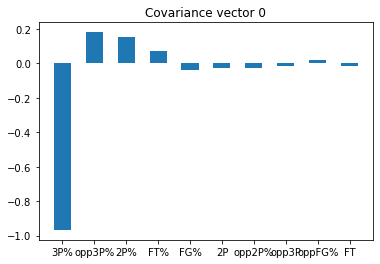

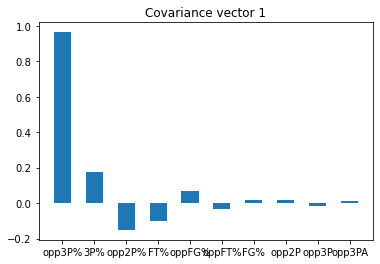

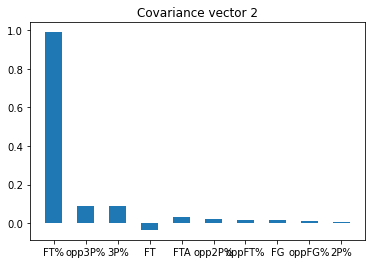

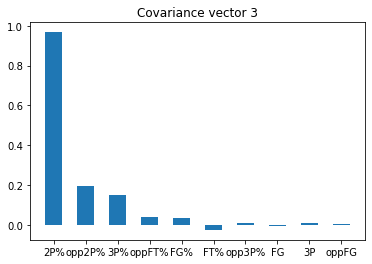

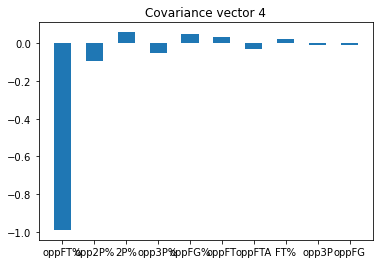

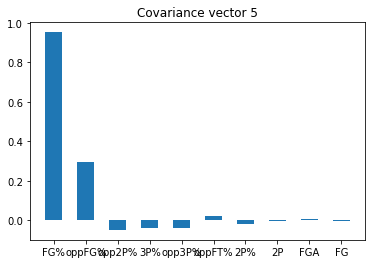

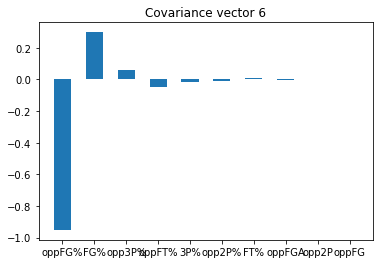

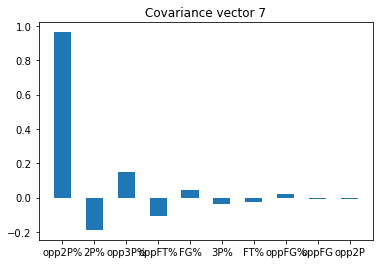

In [16]:
# find max abs of each vector
maxes = np.abs(covVec).max(axis=0)
maxInds = maxes >= 0.89
print(type(maxInds))
selectedVecs = covVec[:,maxInds]
for i in range(selectedVecs.shape[1]):
    # TODO: make the string displayed here show the rank of the corresponding eigenvalue
    visualizeVector(selectedVecs[:,i],' '+str(i))

Very interesting! The tendency is that
1. Each shooting accuracy stat is mostly uncorrelated for all other stats, and
2. the most significant correlations are with other shooting accuracy stats.

I believe these are some of the lowest ranked covariance eigenvectors as well. So, apparently,
1. there is a lot less variation in season-average shooting percentages among teams compared with other statistical categories, and
2. shooting percentages as a group are mostly independent of all other statistical categories.

This is somewhat surprising---I would have at least expected a strong correlation between the percentage on a certain shot and actual makes of the same shot, but even these correlations are very feeble. There is a lot more variation accounted for by shot attempts and makes. Of course, this does not necessarily mean one or the other stat will have better predictive power. My approach is assuming that the top PCs will also have the most predictive capacity. However, is it possible that top PCs are top because they are subject to the most noise, as opposed to having the most "signal," in terms of predictive capacity?

Make a data frame where columns are each teams projection into PCA basis, which can be used for multi bar graph. 

In [17]:
nBasis = 7 # number of top PCA vectors to use
PCABasis = covVec[:,inds[-1:(-nBasis-1):-1]] # pick out basis vectors
PCABasis.shape


(42, 7)

In [18]:
teamDataPCA = np.dot(teamDataZero,PCABasis) # project team data onto PCA basis
teamDataPCA.shape

(626, 7)

In [19]:
dfTeamData.loc[:,'Season':'Tm'].tail()

,Season,Tm
16,2004-05,DAL
17,2003-04,DAL
18,2002-03,DAL
19,2001-02,DAL
20,2000-01,DAL


In [20]:
# create keys
keys = ['Season','Tm'] + list(range(1,nBasis+1))
# create values
values = [dfTeamData['Season'].to_list(),
          dfTeamData['Tm'].to_list()]
for i in range(nBasis):
    values.append(teamDataPCA[:,i])
teamPCADict = dict(zip(keys,values)) # data mapping
dfTeamPCA = pd.DataFrame(teamPCADict)
dfTeamPCA.head()

,Season,Tm,1,2,3,4,5,6,7
0,2020-21,OKC,-32.027865,2.535006,-4.762177,-5.166605,6.907563,-5.927464,-2.866416
1,2019-20,OKC,-23.401911,1.493643,0.045024,0.308754,-2.211891,-5.811204,-0.119296
2,2018-19,OKC,-27.196824,-7.553363,-0.795859,0.733566,-3.809104,3.749856,-5.360385
3,2017-18,OKC,-18.258326,4.667378,-3.629863,0.204161,-4.331368,-0.215230,-2.312704
4,2016-17,OKC,-10.405980,-3.723964,0.672684,1.655268,-2.962475,-0.269232,-2.766122


Make a graph of some of the teams' PCA projections from the 2020-2021 season

In [21]:
dfTeamPCA.loc[0,'Season']

'2020-21'

In [22]:
dfTeamPCA2020 = dfTeamPCA[dfTeamPCA['Season'] == '2020-21']
dfTeamPCA2020

,Season,Tm,1,2,3,4,5,6,7
0,2020-21,OKC,-32.027865,2.535006,-4.762177,-5.166605,6.907563,-5.927464,-2.866416
21,2020-21,LAC,-28.151684,7.299404,0.851785,-1.033189,-4.107081,1.026468,3.964831
42,2020-21,CHI,-28.185703,2.180484,-1.720908,-4.027932,-0.588262,2.706277,3.334578
63,2020-21,CLE,-21.503647,2.080809,-6.327890,-1.878451,3.431596,-5.029743,1.388255
84,2020-21,NOP,-31.705496,-4.029019,-7.264824,1.336803,-7.905472,-5.187911,-0.955325
103,2020-21,SAC,-31.005409,-4.332712,-1.501050,0.544153,2.430813,-0.175410,6.071753
124,2020-21,MIA,-31.069083,15.793501,-7.813896,1.197299,-1.804341,-3.221091,2.144116
145,2020-21,GSW,-34.841105,4.888057,0.796552,3.219079,2.539509,4.594813,0.184762
166,2020-21,LAL,-22.620407,4.469835,-1.901153,-0.275525,-3.897805,-2.239540,0.370130
187,2020-21,POR,-37.759308,4.447860,1.273271,1.878345,2.083885,1.321922,0.777341


In [23]:
dfTeamPCA2020.mean()

1   -30.588450
2     2.450468
3    -2.306840
4    -0.327161
5    -0.802864
6    -0.498144
7     0.903376
dtype: float64

There appears to be a strong correlation with first PCA component and time (i.e., season). Let me check for time variation of mean of each component for each season.

In [24]:
meanSeries = dfTeamPCA[dfTeamPCA["Season"] == '2020-21'].mean()
type(dfTeamPCA[dfTeamPCA["Season"] == '2020-21'].mean())

pandas.core.series.Series

In [25]:
meanSeries.index

Index([1, 2, 3, 4, 5, 6, 7], dtype='object')

In [26]:
meanSeries.name = '2020-21'
meanSeries.name

'2020-21'

I just realized I'm missing some data---the Seattle supersonics! Oh wait no---that's the team OKC used to be. So apparently NBA had only 29 teams from 2000-01 season to 2003-04 season, and starting in 2004-05 it bumped up to 30 teams.

In [27]:
# unique seasons
seasons = pd.unique(dfTeamPCA["Season"])

In [28]:
meanSeries = []
stdSeries = []
for season in seasons:
    df = dfTeamPCA[dfTeamPCA["Season"] == season]
    # compute means and add to series list
    means = df.mean()
    means.name = season
    meanSeries.append(means)
    stds = df.std()
    stds.name = season
    stdSeries.append(stds)

dfMean = (pd.DataFrame(meanSeries)).T
dfStds = (pd.DataFrame(stdSeries)).T

In [29]:
dfMean

,2020-21,2019-20,2018-19,2017-18,2016-17,2015-16,2014-15,2013-14,2012-13,2011-12,...,2009-10,2008-09,2007-08,2006-07,2005-06,2004-05,2003-04,2002-03,2001-02,2000-01
1,-30.588450,-29.140461,-25.848468,-17.203794,-13.217780,-6.499164,-1.627901,-0.920459,3.701758,7.849679,...,5.037581,5.747885,5.474860,8.868471,11.899850,11.865392,15.783719,14.650012,13.967219,16.201421
2,2.450468,0.778789,-2.565319,2.735054,1.110145,0.355529,1.747597,0.365902,2.273533,2.479408,...,-2.383588,-0.564544,-1.766780,-0.158067,1.044305,-1.585048,1.563541,-1.708909,-2.571598,-2.853678
3,-2.306840,-1.851462,-0.626911,-1.459674,-0.859780,-0.170332,-0.200378,-0.089915,-0.236569,0.119861,...,0.748729,0.236341,0.586066,0.002341,-0.009803,0.806140,0.578775,1.320275,1.566351,1.646433
4,-0.327161,1.450843,-0.093890,-2.061918,-0.347240,-1.418817,-2.643166,-0.494013,-3.389471,-3.788868,...,0.979718,2.236546,1.421637,4.686657,4.779711,3.269329,-1.208451,-0.979767,-2.509848,-0.646613
5,-0.802864,-0.431983,-0.595641,-0.384835,-0.293307,0.017905,0.178069,0.011754,0.101949,0.330123,...,-0.205625,-0.136550,-0.086864,0.019459,0.197294,0.290071,0.691541,0.481449,0.339613,0.500132
6,-0.498144,-0.052379,0.307530,-0.334331,-0.197505,0.120540,0.008908,-0.015373,-0.260952,-0.234241,...,-0.112586,-0.291132,-0.014897,-0.135298,-0.188085,0.264344,0.252301,0.499655,0.462598,0.694064
7,0.903376,-1.295859,-1.293488,0.375912,-0.131820,-1.374006,-1.129879,-0.012686,0.917746,0.176586,...,1.947065,1.962772,1.102503,1.221446,0.437422,-0.704090,-1.772041,-1.290022,-0.527588,-1.692921


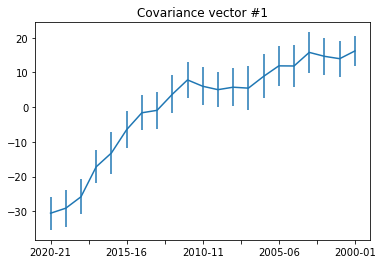

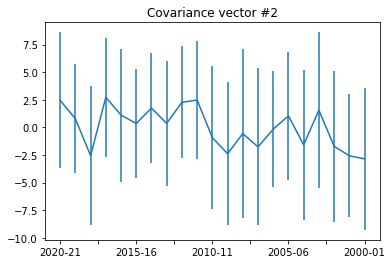

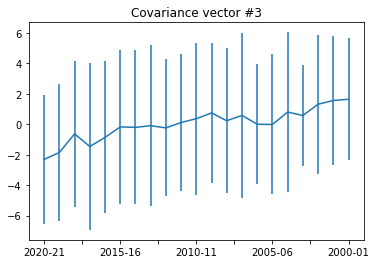

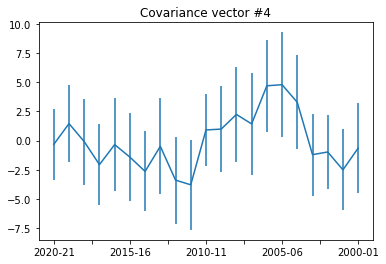

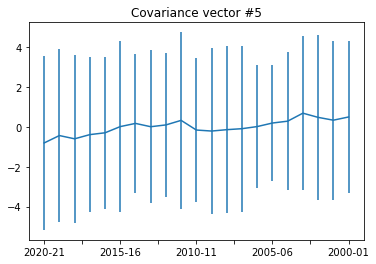

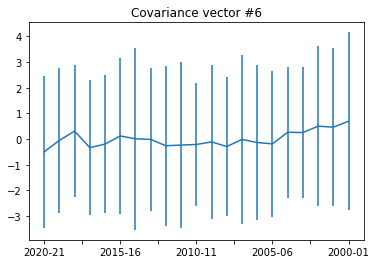

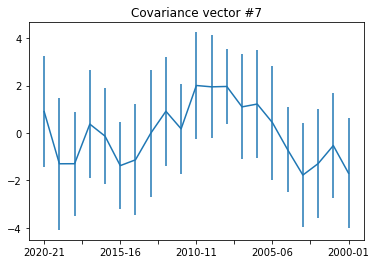

In [30]:
for i in range(1,8):
    plt.figure()
    dfMean.loc[i].plot(yerr=dfStds.loc[i])
    plt.title('Covariance vector #'+str(i))

Covariance vector # 1 is the only one that shows real significant secular variation over the years. Others seem to fluctuate about zero. Seems to reflect the known trend in the league of teams shooting more and more 3s.

Double checking that there is not much variability among shot percentage, with 3P% as a random example.

In [31]:
print(dfTeamData['3P%'].mean())
print(dfTeamData['3P%'].std())

0.3553210862619808
0.019359605849762204


In [32]:
print((dfTeamData[dfTeamData['Season'] == '2015-16'])['3P%'].mean())

0.3527666666666666


# Looking at a few teams PCA profiles from this past season

In [33]:
thisSeason = dfTeamPCA[dfTeamPCA["Season"] == '2020-21']
# subtract mean of PCA component 1 from this season's data
thisSeason.loc[:,1] = thisSeason.loc[:,1] - dfMean.loc[1,'2020-21']


/Users/saberman/opt/anaconda3/envs/notebooks/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:>

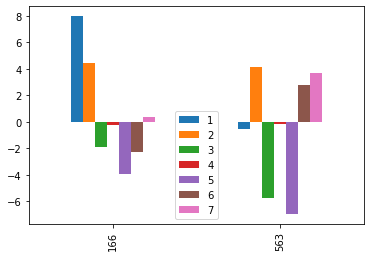

In [34]:
thisSeason[thisSeason['Tm'].isin(['DEN','LAL'])].plot(kind='bar')

In [35]:
thisSeason

,Season,Tm,1,2,3,4,5,6,7
0,2020-21,OKC,-1.439415,2.535006,-4.762177,-5.166605,6.907563,-5.927464,-2.866416
21,2020-21,LAC,2.436766,7.299404,0.851785,-1.033189,-4.107081,1.026468,3.964831
42,2020-21,CHI,2.402747,2.180484,-1.720908,-4.027932,-0.588262,2.706277,3.334578
63,2020-21,CLE,9.084803,2.080809,-6.327890,-1.878451,3.431596,-5.029743,1.388255
84,2020-21,NOP,-1.117046,-4.029019,-7.264824,1.336803,-7.905472,-5.187911,-0.955325
103,2020-21,SAC,-0.416959,-4.332712,-1.501050,0.544153,2.430813,-0.175410,6.071753
124,2020-21,MIA,-0.480633,15.793501,-7.813896,1.197299,-1.804341,-3.221091,2.144116
145,2020-21,GSW,-4.252655,4.888057,0.796552,3.219079,2.539509,4.594813,0.184762
166,2020-21,LAL,7.968042,4.469835,-1.901153,-0.275525,-3.897805,-2.239540,0.370130
187,2020-21,POR,-7.170858,4.447860,1.273271,1.878345,2.083885,1.321922,0.777341


In [36]:
teamMapping = thisSeason['Tm'].to_dict()
thisSeason = thisSeason.reindex(columns=list(range(1,nBasis+1)))
thisSeason.rename(index=teamMapping,inplace=True)
thisSeason

,1,2,3,4,5,6,7
OKC,-1.439415,2.535006,-4.762177,-5.166605,6.907563,-5.927464,-2.866416
LAC,2.436766,7.299404,0.851785,-1.033189,-4.107081,1.026468,3.964831
CHI,2.402747,2.180484,-1.720908,-4.027932,-0.588262,2.706277,3.334578
CLE,9.084803,2.080809,-6.327890,-1.878451,3.431596,-5.029743,1.388255
NOP,-1.117046,-4.029019,-7.264824,1.336803,-7.905472,-5.187911,-0.955325
SAC,-0.416959,-4.332712,-1.501050,0.544153,2.430813,-0.175410,6.071753
MIA,-0.480633,15.793501,-7.813896,1.197299,-1.804341,-3.221091,2.144116
GSW,-4.252655,4.888057,0.796552,3.219079,2.539509,4.594813,0.184762
LAL,7.968042,4.469835,-1.901153,-0.275525,-3.897805,-2.239540,0.370130
POR,-7.170858,4.447860,1.273271,1.878345,2.083885,1.321922,0.777341


<AxesSubplot:>

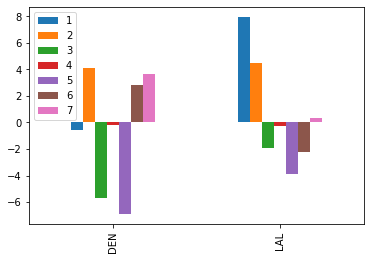

In [37]:
thisSeason.loc[['DEN','LAL']].plot(kind='bar')

In [38]:
covVecNames = {1 : 'SIBO',
              2 : 'TOBI',
              3 : 'MSM',
              4 : 'PHYS',
              5 : 'SQUA',
              6 : 'FOUL',
              7 : 'ALL*'}
thisSeason.rename(columns=covVecNames,inplace=True)

<AxesSubplot:>

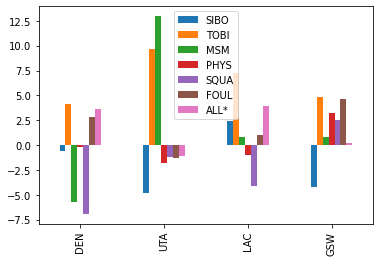

In [39]:
thisSeason.loc[['DEN','UTA','LAC','GSW']].plot(kind='bar')

<AxesSubplot:>

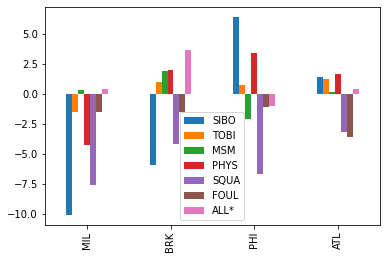

In [40]:
thisSeason.loc[['MIL','BRK','PHI','ATL']].plot(kind='bar')

<AxesSubplot:>

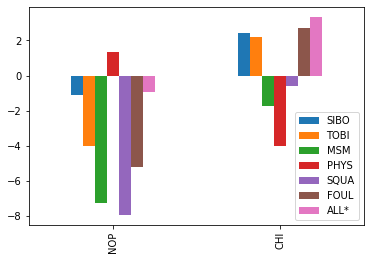

In [41]:
thisSeason.loc[['NOP','CHI']].plot(kind='bar')